# Import data

In [3]:
#disable some annoying warning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import pandas.io.json as json
import geopy as geo
import time as time

from IPython.html.widgets import interact, interact_manual

#from yelp.client import Client
#from yelp.oauth1_authenticator import Oauth1Authenticator

C:\Users\Markus\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Users\Markus\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Helper methods

Because there is no parent JSON object, I have to read the file line by line

In [4]:
# http://stackoverflow.com/questions/30088006/cant-figure-out-how-to-fix-the-error-in-the-following-code
def load_json_line_by_line(file_path):
    # read the entire file into a python array
    f = open(file_path, 'r')
    data = f.readlines()
    f.close()
    
    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    # create one big JSON array, with each line being one entry
    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas (and normalize it got)
    data_df = json.json_normalize(json.loads(data_json_str))
    
    return data_df

In [5]:
def make_object_tuple(x):
    if(type(x) == 'list'):
        return tuple(map(lambda ele: make_object_tuple(ele), x))
    else:
        return x

Make columns which contains lists (like the categories column) to columns of tuples so the are hashable

In [6]:
# Lists like [[Coffee & Tea, coffee], [Bakeries, bakeries]] 
# have to be converted to tuples like ((Coffee & Tea, coffee), (Bakeries, bakeries))
# to be hashable

# Keeping this slow version just for demo purpose
def convert_listcolumns_to_tuplecolumns_old(df, col_names):
    i = 0
    for col_name in col_names:
        for row in df.iterrows():
            i = i+1
            print(str(i/len(df)) + "%")
            row[col_name] = eval(str(row[col_name]).replace('[','(').replace(']',')'))
    return df

In [7]:
def convert_listcolumns_to_tuplecolumns(df, col_names):
    for col_name in col_names:
        df[col_name] = df.apply(lambda row: eval(str(row[col_name]).replace('[','(').replace(']',')')), axis=1)
    return df

Converts columns with time to integer columns (e.g., 17:00 -> 1700)

In [8]:
def convert_timecolumns_to_numbercolumns(df, col_names):
    for col_name in col_names:
        df[col_name] = df.apply(lambda row: eval(str(row[col_name]).replace(':','.')), axis=1)
    return df

Converts any column to a string column

In [9]:
def convert_columns_to_stringcolumns(df, col_names):
    for col_name in col_names:
        df[col_name] = df.apply(lambda row: str(row[col_name]), axis=1)
    return df

Converts any column into a category column.

EDIT:
Note In contrast to R’s factor function, categorical data is not converting input values to strings and categories will end up the same data type as the original values.
-> Okay, then this is not really applicable

In [10]:
def convert_columns_to_categorical(df, col_names):
    for col_name in col_names:
        df[col_name] = df[col_name].astype('category')
    return df

Because many attributes are boolean we want to convert them from object to bool

In [11]:
def convert_columns_to_bool(df, col_names):
    for col_name in col_names:
        tmp = df[col_name].astype('category')
        if True in tmp.cat.categories or False in tmp.cat.categories:
            df[col_name] = df[col_name].astype('bool')
    return df

# Load data

Load the businesses from the dataset.

The dataset is a .json file, therefor we have to use methods form pandas.io.json to load the data.

On loading the data, it also gets normalized, that means substructures get flattend out and get added as single columns (most of the columns which start with attribute.* or hours.*)

Also set the index column to the businesses name.

In [12]:
start_time = time.time()
businesses = load_json_line_by_line("yelp_academic_dataset_business.json")
businesses.index = businesses.pop('name')
print('Data loading took ' + str(time.time() - start_time) + " seconds.")

Data loading took 21.795461177825928 seconds.


# Basic overview

Let's have a first look at the data.
We can use head() for this.

In [13]:
businesses.head()

,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Wednesday.close,hours.Wednesday.open,latitude,longitude,neighborhoods,open,review_count,stars,state,type
name,,,,,,,,,,,,,,,,,,,,,
"Eric Goldberg, MD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17:00,08:00,33.499313,-111.983758,[],True,9,3.5,AZ,business
Clancy's Pub,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40.350519,-79.886930,[],True,4,3.5,PA,business
Cool Springs Golf Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40.356896,-80.015910,[],False,5,2.5,PA,business
Verizon Wireless,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21:00,10:00,40.357620,-80.059980,[],True,3,3.5,PA,business
Emil's Lounge,True,NaN,NaN,full_bar,False,False,False,False,False,False,...,19:00,10:00,40.408735,-79.866351,[],True,11,4.5,PA,business


# Conclusion from basic overview:

* We have many columns (104 + index!)
* We have many NaN attributes in the attributes columns
* We have list columns which have to be converted to tuples

# Convert list columns to tuple columns:

In [14]:
businesses = convert_listcolumns_to_tuplecolumns(businesses, ['categories','neighborhoods'])
businesses.head()

,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Wednesday.close,hours.Wednesday.open,latitude,longitude,neighborhoods,open,review_count,stars,state,type
name,,,,,,,,,,,,,,,,,,,,,
"Eric Goldberg, MD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17:00,08:00,33.499313,-111.983758,(),True,9,3.5,AZ,business
Clancy's Pub,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40.350519,-79.886930,(),True,4,3.5,PA,business
Cool Springs Golf Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40.356896,-80.015910,(),False,5,2.5,PA,business
Verizon Wireless,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21:00,10:00,40.357620,-80.059980,(),True,3,3.5,PA,business
Emil's Lounge,True,NaN,NaN,full_bar,False,False,False,False,False,False,...,19:00,10:00,40.408735,-79.866351,(),True,11,4.5,PA,business


# Column overview:

Because there are so many columns, let's get an overview which columns are there:

In [15]:
for col in businesses.columns:
    print(col)

attributes.Accepts Credit Cards
attributes.Accepts Insurance
attributes.Ages Allowed
attributes.Alcohol
attributes.Ambience.casual
attributes.Ambience.classy
attributes.Ambience.divey
attributes.Ambience.hipster
attributes.Ambience.intimate
attributes.Ambience.romantic
attributes.Ambience.touristy
attributes.Ambience.trendy
attributes.Ambience.upscale
attributes.Attire
attributes.BYOB
attributes.BYOB/Corkage
attributes.By Appointment Only
attributes.Caters
attributes.Coat Check
attributes.Corkage
attributes.Delivery
attributes.Dietary Restrictions.dairy-free
attributes.Dietary Restrictions.gluten-free
attributes.Dietary Restrictions.halal
attributes.Dietary Restrictions.kosher
attributes.Dietary Restrictions.soy-free
attributes.Dietary Restrictions.vegan
attributes.Dietary Restrictions.vegetarian
attributes.Dogs Allowed
attributes.Drive-Thru
attributes.Good For Dancing
attributes.Good For Groups
attributes.Good For Kids
attributes.Good For.breakfast
attributes.Good For.brunch
attribute

# Conclusion from column overview

Whoa! That's a whole bunch of columns. Can't wait to analyze them.

But first we have to think about missing data.

# Check which columns never contain NaN

In [16]:
for col in businesses.dropna(axis = 1, how = 'any', thresh = None, subset = None, inplace = False).columns:
    print(col)

business_id
categories
city
full_address
latitude
longitude
neighborhoods
open
review_count
stars
state
type


Okay, this base columns look pretty promising: Name, type, categories, location, state, review_count and stars are available for every location

# Check if columns contain interesting information

In [17]:
businesses["type"].unique()

array(['business'], dtype=object)

Okay, we can forget about the type column, this column does not add information

In [18]:
businesses = businesses.drop('type', 1)

In [19]:
businesses["neighborhoods"].unique()

array([(), 'Greentree', 'Carnegie', 'Homestead', 'Hays', 'South Side',
       'Bellevue', 'Avalon', 'Windgap', 'Crafton Heights', 'Friendship',
       'Morningside', 'Point Breeze', 'East Liberty', 'Shadyside',
       'Larimer', 'Highland Park', ('Garfield', 'Friendship'),
       'Bloomfield', 'Homewood', 'Mt. Oliver', 'Downtown', 'Allentown',
       'Carrick', 'Overbrook', 'Brookline', 'North Side', 'Etna',
       'Troy Hill', 'Oakland', 'Lawrenceville', 'Brighton Heights',
       'Observatory Hill', 'Banksville', 'Dormont',
       ('Banksville', 'Beechview'), ('Dormont', 'Banksville'), 'Beechview',
       'West End', 'Strip District', 'Garfield', 'Bon Air',
       ('Shadyside', 'Bloomfield'), ('Shadyside', 'Friendship'),
       'The Hill District', 'Starmount', 'Dilworth', 'Ballantyne',
       'South Park', 'Uptown', 'Fourth Ward', 'First Ward', 'Third Ward',
       'Arboretum', 'Myers Park', ('South End', 'Dilworth'),
       ('Dilworth', 'Myers Park'), 'Cotswold', 'South End', 'Eliz

Keep it, probably we may need it in the future

# Example code to get businesses with a given attribute set

Here some code to select only rows which don't have NaN values in certain columns

In [20]:
must_contain_value_in_columns = ['attributes.Accepts Credit Cards']
businesses.dropna(axis = 0, how = 'any', thresh = None, subset = must_contain_value_in_columns, inplace = False)

,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,latitude,longitude,neighborhoods,open,review_count,stars,state
name,,,,,,,,,,,,,,,,,,,,,
Clancy's Pub,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.350519,-79.886930,(),True,4,3.5,PA
Emil's Lounge,True,NaN,NaN,full_bar,False,False,False,False,False,False,...,10:00,19:00,10:00,40.408735,-79.866351,(),True,11,4.5,PA
Alexion's Bar & Grill,True,NaN,NaN,full_bar,True,False,False,False,False,False,...,NaN,NaN,NaN,40.415517,-80.067534,Greentree,True,15,4.0,PA
Kings Family Restaurant,True,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,08:00,02:00,08:00,40.387732,-80.092874,(),True,8,3.5,PA
Shop N'save,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.387732,-80.092874,(),True,3,3.5,PA
Rocky's Lounge,True,NaN,NaN,full_bar,False,False,False,False,False,False,...,NaN,NaN,NaN,40.396469,-80.084942,(),True,5,4.0,PA
Gab & Eat,False,NaN,NaN,none,True,False,True,False,False,False,...,06:00,14:30,06:00,40.396744,-80.084800,(),True,38,4.5,PA
Barb's Country Junction Cafe,True,NaN,NaN,none,False,False,False,False,False,False,...,NaN,NaN,NaN,40.404638,-80.089985,Carnegie,True,5,4.0,PA
Extended Stay America - Pittsburgh - Carnegie,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,00:00,00:00,00:00,40.417419,-80.088557,Carnegie,True,5,4.0,PA


Let's see if there are businesses which have all attributes set

In [21]:
attributes = list()

for col in businesses:
    if col.startswith('attributes'):
        attributes.append(col)

businesses.dropna(axis = 0, how = 'any', thresh = None, subset = attributes, inplace = False)

,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,latitude,longitude,neighborhoods,open,review_count,stars,state
name,,,,,,,,,,,,,,,,,,,,,


As I thought, there is not a single business with all attributes set

# Some statistics

The general description

In [22]:
businesses.describe()

,attributes.Price Range,latitude,longitude,open,review_count,stars
count,41694.000000,61184.000000,61184.000000,61184,61184.000000,61184.000000
mean,1.800283,37.326077,-97.491803,0.878089,28.272506,3.673305
std,0.717469,5.741085,29.624473,0.327186,88.652050,0.891207
min,1.000000,32.871923,-115.386550,False,3.000000,1.000000
25%,1.000000,33.509601,-115.052224,1,4.000000,3.000000
50%,2.000000,35.994636,-111.932944,1,8.000000,3.500000
75%,2.000000,36.240430,-80.863329,1,21.000000,4.500000
max,4.000000,56.036545,8.549249,True,4578.000000,5.000000


Mean review count and rating per category and per state

In [23]:
businesses.groupby(['categories']).agg({'stars' : 'mean', 'review_count': 'mean', 'full_address' : 'count'})

,stars,review_count,full_address
categories,,,
(),3.401354,5.015474,517
"(Accessories, Fashion, Shopping, Cosmetics & Beauty Supply, Beauty & Spas)",3.000000,9.000000,1
"(Accessories, Fashion, Shopping, Shoe Stores, Jewelry)",5.000000,3.000000,1
"(Accountants, Professional Services)",3.750000,4.687500,16
"(Accountants, Professional Services, Bookstores, Shopping, Books, Mags, Music & Video)",5.000000,4.000000,1
"(Accountants, Professional Services, Payroll Services, Financial Advising, Financial Services)",5.000000,11.000000,1
"(Accountants, Professional Services, Payroll Services, Tax Services, Financial Services)",4.375000,3.750000,4
"(Accountants, Professional Services, Tax Services, Financial Advising, Financial Services)",5.000000,6.000000,3
"(Accountants, Professional Services, Tax Services, Financial Services)",4.533333,5.800000,15


In [24]:
businesses.groupby(['state']).agg({'stars' : 'mean', 'review_count': 'mean', 'full_address' : 'count'})

,stars,review_count,full_address
state,,,
AZ,3.684503,25.238962,25230
BW,3.766595,9.368308,934
CA,3.333333,14.333333,3
EDH,3.793167,11.560417,2971
ELN,3.600000,5.100000,10
FIF,3.500000,9.000000,4
HAM,4.500000,3.000000,1
IL,3.569378,20.987241,627
KHL,3.500000,8.000000,1


Overview over the different attributes and their relation to review_count and rating

In [25]:
for attribute in attributes:
    res = businesses.groupby([attribute]).agg({'stars' : 'mean', 'review_count': 'mean'})
    print(res)

                                    stars  review_count
attributes.Accepts Credit Cards                        
False                            3.879247     18.418274
True                             3.638509     35.334864
                                 stars  review_count
attributes.Accepts Insurance                        
False                         4.171355     24.166240
True                          4.171642     13.253731
                            stars  review_count
attributes.Ages Allowed                        
18plus                   3.197674     20.534884
19plus                   3.300000     12.200000
21plus                   3.348214    151.815476
allages                  3.500000     44.315789
                       stars  review_count
attributes.Alcohol                        
beer_and_wine       3.666778     65.650352
full_bar            3.518249     77.763921
none                3.488340     34.605354
                               stars  review_count
attributes

I found the attribute price range. That looks promising for a comparism between price and rating!

Let's have a look at the statstics:

In [26]:
must_contain_value_in_columns = ['attributes.Price Range']
price_range_businesses = businesses.dropna(axis = 0, how = 'any', thresh = None, subset = must_contain_value_in_columns, inplace = False)
price_range_businesses.groupby("attributes.Price Range").agg({"stars": 'mean'})

,stars
attributes.Price Range,
1,3.575422
2,3.664086
3,3.641588
4,3.561155


That are not really the result I hoped to see... I hoped for some clustering like " -10 dollar", "10-20 dollar", etc.
But at least we see that the price range does not have that much of an influence regarding rating.
So this column does not really contain valuable information.

# Plotting

Where are all the businesses?

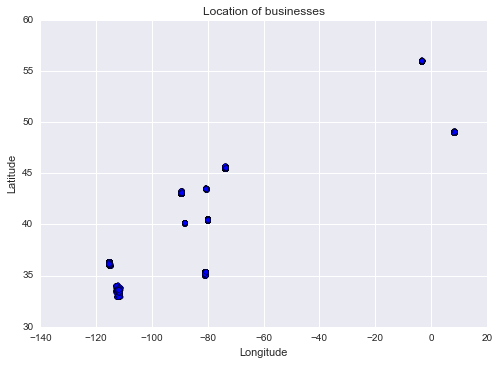

In [27]:
plt.scatter(businesses["longitude"], businesses["latitude"])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Location of businesses')

Okay, yet we didn't know exactly what this Yelp challenge dataset contained.
Now we know that the dataset contains american businesses.

Let's see when most of them open:

In [28]:
opening_times_columns = [
    'hours.Monday.open', 'hours.Tuesday.open', 'hours.Wednesday.open', 'hours.Thursday.open', 'hours.Friday.open', 'hours.Saturday.open', 'hours.Sunday.open',
    'hours.Monday.close', 'hours.Tuesday.close', 'hours.Wednesday.close', 'hours.Thursday.close', 'hours.Friday.close', 'hours.Saturday.close', 'hours.Sunday.close'
]

businesses_with_opening_times = businesses.dropna(axis = 0, how = 'any', thresh = None, subset = opening_times_columns, inplace = False)

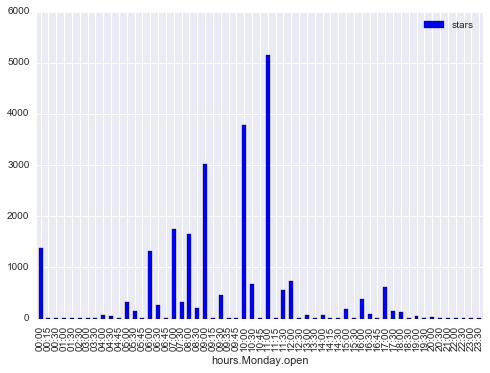

In [29]:
@interact(day=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], open_close=['open','close'])
def show_opening_times(day, open_close):
    group = businesses_with_opening_times.groupby('hours.' + day + "." + open_close)
    group.agg({'stars' : 'count'}).plot(kind='bar')

Let's take first steps into heatmaps and clustermaps:
Do the opening and closing times of the different days correlate to each other?

C:\Users\Markus\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


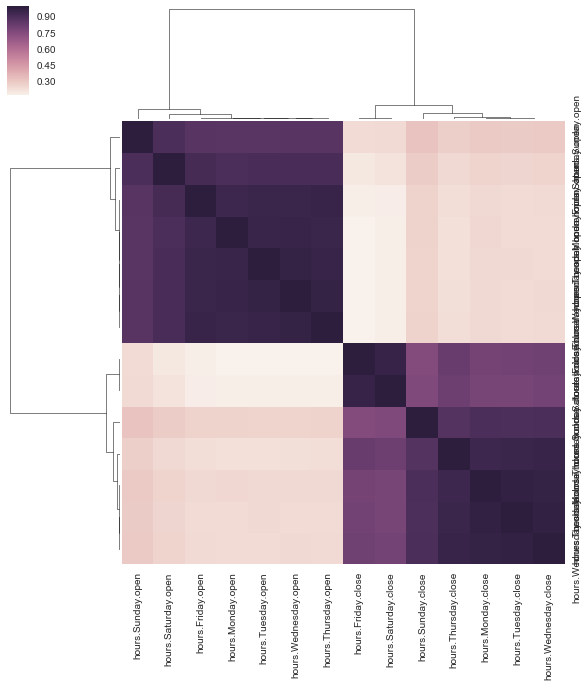

In [30]:
corrmat = convert_timecolumns_to_numbercolumns(businesses_with_opening_times, opening_times_columns)[opening_times_columns].corr()

# draw a clustered heatmap using seaborn
sns.clustermap(corrmat, square=True)

As expected, the opening times mostly correlate to each other during monday to friday, with a second "correlation pair" on saturday and sunday. (Special opening times on the weekend).

Also, the closing times of friday and saturday correlate much more to each other than to the other days.

As next let's have a look at the number of review count and stars to get a coarse feeling for how average ratings on help look like.

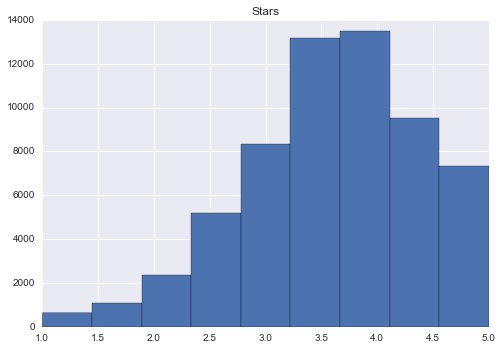

In [31]:
plt.hist(businesses['stars'],bins=9)
plt.title('Stars')

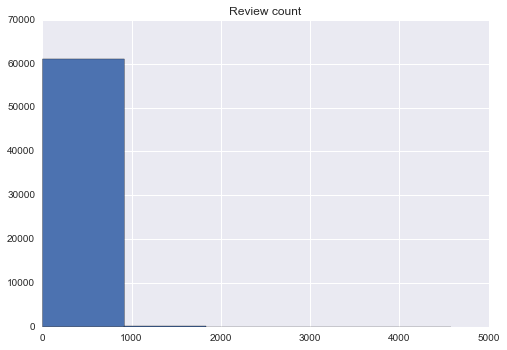

In [32]:
plt.hist(businesses['review_count'],bins=5)
plt.title('Review count')

As we can see: we don't see much, because there are very very few locations with very much reviews. Let's try another visualisation method.

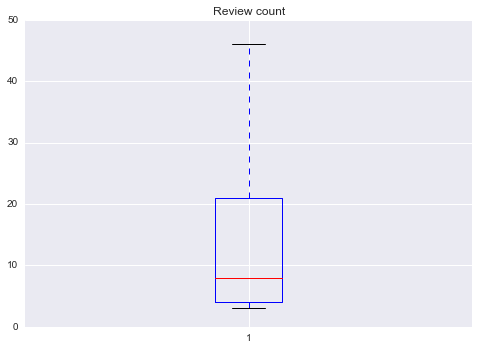

In [33]:
plt.boxplot(businesses['review_count'], 0, '') # Outliners are not shown
plt.title('Review count')

A boxplot which does not show points for the outliners is a much better choice for visualizing this.

Now let's get an overview over the different attributes and ratings

In [34]:
#stringcategory_businesses = convert_columns_to_stringcolumns(businesses, ["categories"])
#food_businesses = stringcategory_businesses[stringcategory_businesses["categories"].str.contains('Food')]
#food_businesses["categories"].unique()
#plt.hist(food_businesses[food_businesses["categories"].str.contains(str(category))]["stars"],bins=9)
#plt.title('Stars of businesses with categories ' + str(category))

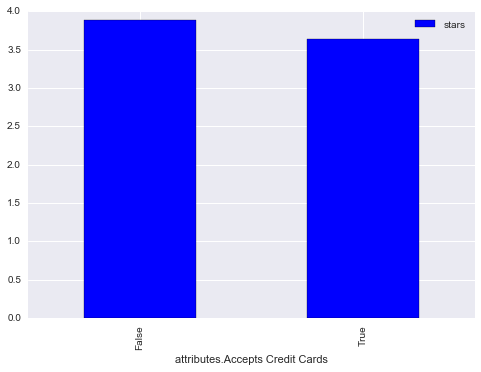

In [35]:
@interact(category=tuple(sorted(attributes)))
def show_stars_per_category(category):
    businesses.groupby(category).agg({'stars' : 'mean'}).plot(kind='bar')

Average rating per state

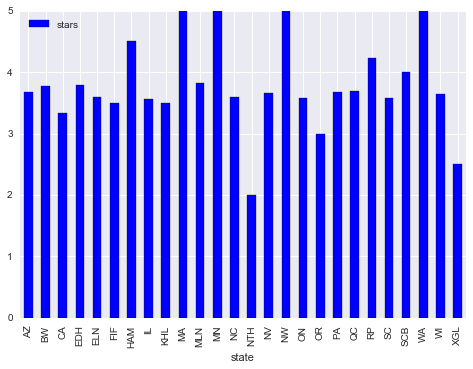

In [36]:
businesses.groupby("state").agg({'stars' : 'mean'}).plot(kind='bar')

Number of businneses per state

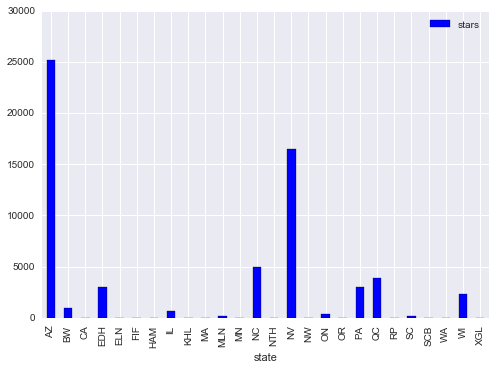

In [37]:
businesses.groupby("state").agg({'stars' : 'count'}).plot(kind='bar')

This is some interesting result. For some states we just have very few businesses. This may be considered in further analysis.

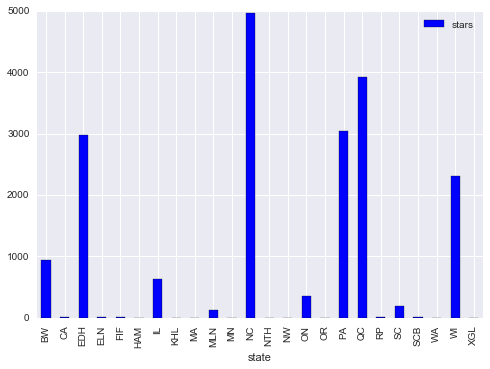

In [38]:
idx = businesses['state'].isin(['AZ', 'NV'])
businesses_without_AZ_NV = businesses[~idx]
businesses_without_AZ_NV.groupby("state").agg({'stars' : 'count'}).plot(kind='bar')

Okay, now we get to the point. I will now include in the number of businesses in the descriptive statistics analysis. If we now look at the statistics again, it get's clear that there is a huge difference in the amount of data per state.

Now let's see if businessis which have a high review_count (and therefor probably are often visited) also have a higher rating

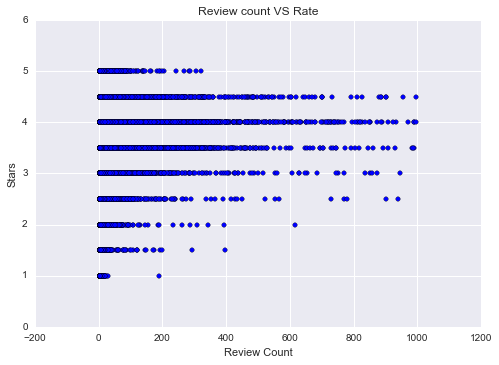

In [55]:
plt.scatter(businesses[businesses["review_count"]<1000]["review_count"], businesses[businesses["review_count"]<1000]["stars"])
plt.xlabel('Review Count')
plt.ylabel('Stars')
plt.title('Review count VS Rate')

This is not the optimal visalisation method, let's try it with a differnt method

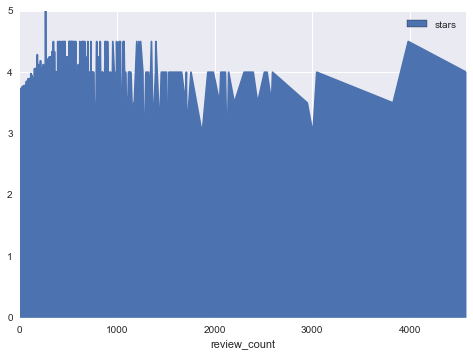

In [66]:
businesses.groupby("review_count").agg({"stars": "mean"}).plot(kind='area')

This does not really look like a monotone growing curve. So the assumption that more often rated businesses have higher ratings is not true

And just again to repeat the findings from the statistics: The attribute "Price Range" does not really have a high influence on the rating.

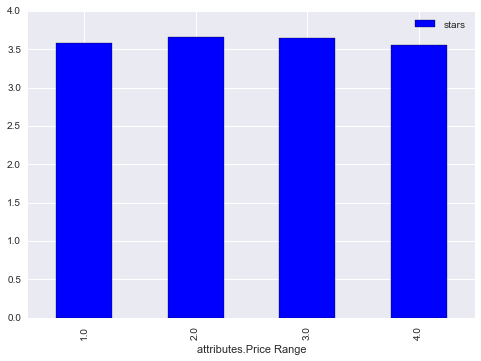

In [69]:
price_range_businesses = businesses.dropna(axis = 0, how = 'any', thresh = None, subset = must_contain_value_in_columns, inplace = False)
price_range_businesses.groupby("attributes.Price Range").agg({"stars": 'mean'}).plot(kind='bar')

ValueError: setting an array element with a sequence.

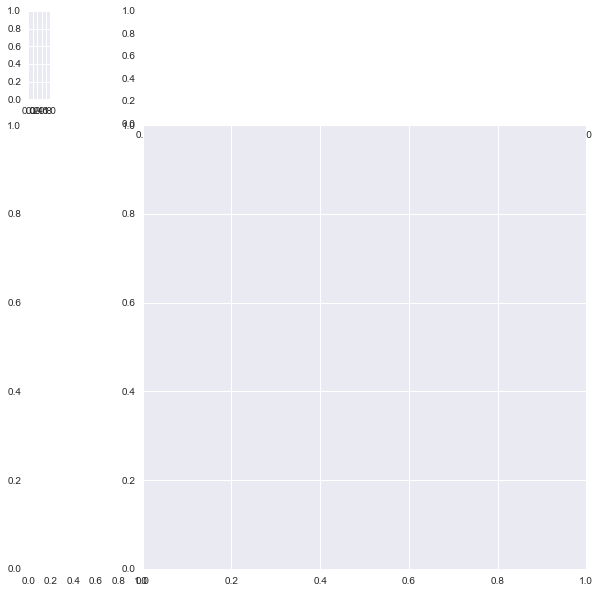